In [1]:
# basics
import numpy as np
import pandas as pd
import datetime
import re
import os,glob

# statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf


# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15,12]

# own data wrappers
from imp import reload
import measureclass as mc; reload(mc);
import coronadataclass as cdc; reload(cdc);

np.seterr(divide = 'ignore');


In [2]:
# load data into datawrapper classes
measure_data = mc.COVID19_measures(datasource = 'Oxford', measure_level = 1, only_first_dates = True, expand_measure_names = True)
jhu_data     = cdc.CoronaData(download_data = False)

# remove and rename countries to match the JHU database and the measures database
#measure_data.RemoveCountry('Diamond Princess')
#measure_data.RenameCountry('France (metropole)', 'France')
#measure_data.RenameCountry('South Korea', 'Korea, South')
#measure_data.RenameCountry('Czech Republic', 'Czechia')



In [3]:
def date2vector(implementdate, start = '22/1/20', end = None, shiftdays = 0):
    # generate vector of 0s and 1s when measure is implemented or not
    starttime     = datetime.datetime.strptime(start,         '%d/%m/%y')
    if end is None:
        endtime   = datetime.datetime.today()
    else:
        endtime   = datetime.datetime.strptime(end,           '%d/%m/%y')
    implementtime = datetime.datetime.strptime(implementdate, '%d/%m/%Y')
    
    totaldays   = (endtime       - starttime).days
    measuredays = (implementtime - starttime).days
    
    vec         = np.zeros(totaldays)
    vec[min(measuredays+shiftdays,len(vec)-1):] = 1
    
    return vec


def ConvertDateFormat(date):
    m,d,y = date.split('/')
    return '{:02d}/{:02d}/{:02d}'.format(int(d),int(m),int(y))


def CleanUpMeasureName(measurename):
    # regression model formula can't contain special characters
    return ''.join([mn.capitalize() for mn in measurename.replace(',','').replace('-','').replace('/','').split(' ')])


def GetMeasureIDs(countrylist = None, measure_level = 2, mincount = None, extend_measure_names = False):
    if countrylist is None:
        countrylist = measure_data.countrylist # use ALL countries
    
    measurelist = {}
    
    # get all restrictions from countries
    for country in countrylist:
        country_measures = measure_data.CountryData(country, measure_level = 2, extend_measure_names = extend_measure_names)
        for measurename, initialdata in country_measures.items():
            if not measurename in measurelist.keys():
                measurelist[measurename] = 0
            measurelist[measurename] += 1
    
    if not mincount is None:
        # rebuild dict with restrictions
        measurelist = {k:v for k,v in measurelist.items() if v >= mincount}

    return measurelist


def SmoothTrajectories3(traj):
    if len(traj) > 3:
        newtraj       = np.zeros(len(traj))
        newtraj[0]    = (             2 * traj[0]    + traj[1] )/3.
        newtraj[1:-1] = (traj[0:-2] + 2 * traj[1:-1] + traj[2:])/4.
        newtraj[-1]   = (traj[-2]   + 2 * traj[-1]             )/3.
        return newtraj
    else:
        return traj


def GetCountryTrajectories(countrylist = None, data = 'Confirmed', startcases = None, maxlen = None, smooth = False):
    if countrylist is None:
        countrylist = jhu_data.countrylist
    
    trajectories = {}
    for country in [c for c in countrylist if c in jhu_data.countrylist]:
        ctraj = np.array(jhu_data.CountryData(country)[data], dtype = np.float)
        starttraj = 0
        if not startcases is None:
            starttraj = np.argmax(ctraj >= startcases)
            ctraj = ctraj[starttraj:]
            if not maxlen is None:
                ctraj = ctraj[:min(maxlen,len(ctraj))]
        trajectories[country] = {}
        if smooth:
            ctraj = SmoothTrajectories3(ctraj)
        trajectories[country]['traj'] = ctraj
        trajectories[country]['startdate'] = ConvertDateFormat(jhu_data.CountryData(country)['Date'][starttraj])
    
    return trajectories

        
def GetRegressionDF(countrylist = None, measure_level = 2, shiftdays = 0, verbose = False, maxlen = None, smooth = None):
    # construct pd.DataFrame used for regression
    
    # get trajectories and measure list for all countries in 'countrylist'
    trajectories         = GetCountryTrajectories(countrylist = countrylist, data = 'Confirmed', startcases = 30, maxlen = maxlen, smooth = smooth)
    measureIDs           = measure_data.MeasureList(countrylist = countrylist, measure_level = 2, mincount = 5)
    cleaned_measurelist  = {CleanUpMeasureName(mn):count for mn,count in measureIDs.items()}
    regressionDF         = None
    
    if verbose:
        print(measureIDs)
    
    for country in trajectories.keys():
        if country in measure_data.countrylist:

            # ********************************************
            # change observable to regress here:
            observable                  = np.diff(np.log(trajectories[country]['traj']))
            obslen                      = len(observable)
            # ********************************************
            
            DF_country = measure_data.ImplementationTable(country           = country,
                                                        measure_level     = 2,
                                                        startdate         = trajectories[country]['startdate'],
                                                        shiftdays         = shiftdays,
                                                        maxlen            = obslen,
                                                        clean_measurename = True)
            
            for measurename in DF_country.columns:
                if measurename not in measureIDs.keys():
                    DF_country.drop(labels = measurename, axis = 'columns')
            
            DF_country['Country']    = country
            DF_country['Observable'] = observable

            
            if not (np.isnan(DF_country['Observable']).any() or np.isinf(DF_country['Observable']).any()):

                if regressionDF is None:
                    regressionDF = DF_country
                else:
                    regressionDF = pd.concat([regressionDF,DF_country], ignore_index = True, sort = False)
    
    # not implemented measures should be NaN values, set them to 0
    regressionDF.fillna(0, inplace = True)
    
    return regressionDF, cleaned_measurelist



def GetCountryMasks(regrDF):
    countrylist = list(regrDF['Country'].unique())
    maskdict = {}
    for country in countrylist:
        mask = list(regrDF['Country'] == country)
        maskdict[country] = mask
    return maskdict



def CrossValidation(data = None, drop_cols = None, outputheader = None, alpha = 1e-5, alphacountry = None, crossvalcount = 10):
    # output df
    result_DF = None
    
    # assign samples to each of the crossvalidation chunks
    datalen = len(data)
    chunklen   = np.ones(crossvalcount,dtype = np.int) * (datalen // crossvalcount)
    chunklen[:datalen%crossvalcount] += 1
    samples    = np.random.permutation(
                    np.concatenate(
                        [i*np.ones(chunklen[i],dtype = np.int) for i in range(crossvalcount)]
                    ))
    
    # generate formula of model directly from columns in DataFrame
    measurelist = list(data.columns)
    measurelist.remove('Observable')
    measurelist.remove('Country')
    
    formula = 'Observable ~ C(Country) + ' + ' + '.join(measurelist)
    
    # iterate over all chunks
    for xv_index in range(crossvalcount):
        # generate training and test models
        trainidx = (samples != xv_index)
        testidx  = (samples == xv_index)
        trainmodel = smf.ols(formula = formula, data = data[trainidx], drop_cols = drop_cols)
        testmodel  = smf.ols(formula = formula, data = data[testidx],  drop_cols = drop_cols)
    
        # if no alphacountry value is given, assume same penalty (alpha) for all paramters
        if alphacountry is None:
            results = trainmodel.fit_regularized(alpha = alpha, L1_wt = 1)
        else:
            # otherwise, penalize measures and countries differently
            # no penality for the 'Intercept'
            alphavec = np.zeros(len(trainmodel.exog_names))
            for i,exogname in enumerate(trainmodel.exog_names):
                if exogname[:10] == 'C(Country)': alphavec[i] = alphacountry
                elif exogname == 'Intercept':     alphavec[i] = 0
                else:                             alphavec[i] = alpha
            results = trainmodel.fit_regularized(alpha = alphavec, L1_wt = 1)

        # generate list of test params
        # random sampling could have discarded some of these parameters in the test case
        test_params = []
        for paramname in testmodel.exog_names:
            if paramname in results.params.keys():
                test_params.append(results.params[paramname])
            else:
                test_params.append(0)

        obs_train   = np.array(trainmodel.endog)
        obs_test    = np.array(testmodel.endog)
        pred_train  = trainmodel.predict(results.params)
        pred_test   = testmodel.predict(test_params)
            
        # store results first in dict
        result_dict = {}
        if outputheader is not None:
            result_dict.update(outputheader)
        
        result_dict['Iteration']        = xv_index
        
        result_dict['Loglike Training'] = trainmodel.loglike(results.params)
        result_dict['Loglike Test']     = testmodel.loglike(np.array(test_params))

        result_dict['R2 Training']      = 1 - np.sum((obs_train - pred_train)**2)/np.sum((obs_train - np.mean(obs_train))**2)
        result_dict['R2 Test']          = 1 - np.sum((obs_test - pred_test)**2)/np.sum((obs_test - np.mean(obs_test))**2)

        result_dict['RSS Training']     = np.sum((obs_train - pred_train)**2)
        result_dict['RSS Test']         = np.sum((obs_test - pred_test)**2)

        result_dict.update({k:v for k,v in results.params.items()})
        
        # append dict to df
        if result_DF is None:
            result_DF = pd.DataFrame({k:np.array([v]) for k,v in result_dict.items()})
        else:
            result_DF = result_DF.append(result_dict, ignore_index = True)
    return result_DF

In [7]:
regrDF   = {}
maxshift = 20
for shiftdays in range(10, maxshift + 1):
    print('shiftdays = {}'.format(shiftdays))
    regrDF[shiftdays], measurelist = GetRegressionDF(countrylist = measure_data.countrylist, shiftdays = shiftdays, smooth = True)


shiftdays = 10


/usr/lib64/python3.7/site-packages/numpy/lib/function_base.py:1273: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


shiftdays = 11
shiftdays = 12
shiftdays = 13
shiftdays = 14
shiftdays = 15
shiftdays = 16
shiftdays = 17
shiftdays = 18
shiftdays = 19
shiftdays = 20


In [8]:


allres = None
for shiftdays in range(10,21):
    for alpha in np.power(10.,np.linspace(-6,-4,num=3)):
        print('{:2d} {:.6f} {}'.format(shiftdays,alpha,datetime.datetime.now().strftime('%H:%M:%S')))
        resultDF = CrossValidation( data         = regrDF[shiftdays],
                                    outputheader = {'shiftdays':shiftdays, 'alpha':alpha},
                                    alpha        = alpha)

        if allres is None:
            allres = resultDF
        else:
            allres = pd.concat([allres, resultDF])
allres.to_csv('data/results_oxforddata_200415_2.csv')

10 0.000001 15:40:35
10 0.000010 15:40:56
10 0.000100 15:41:17
11 0.000001 15:41:34
11 0.000010 15:42:00
11 0.000100 15:42:23
12 0.000001 15:42:41
12 0.000010 15:43:07
12 0.000100 15:43:30
13 0.000001 15:43:48
13 0.000010 15:44:14
13 0.000100 15:44:49
14 0.000001 15:45:13
14 0.000010 15:45:44
14 0.000100 15:46:16
15 0.000001 15:46:48
15 0.000010 15:47:25
15 0.000100 15:48:00
16 0.000001 15:48:24
16 0.000010 15:49:01
16 0.000100 15:49:36
17 0.000001 15:50:05
17 0.000010 15:50:48
17 0.000100 15:51:20
18 0.000001 15:51:45
18 0.000010 15:52:17
18 0.000100 15:52:42
19 0.000001 15:53:03
19 0.000010 15:53:40
19 0.000100 15:54:14
20 0.000001 15:54:41
20 0.000010 15:55:13
20 0.000100 15:55:43


data/results_oxforddata_200415.csv
data/results_oxforddata_200415_2.csv


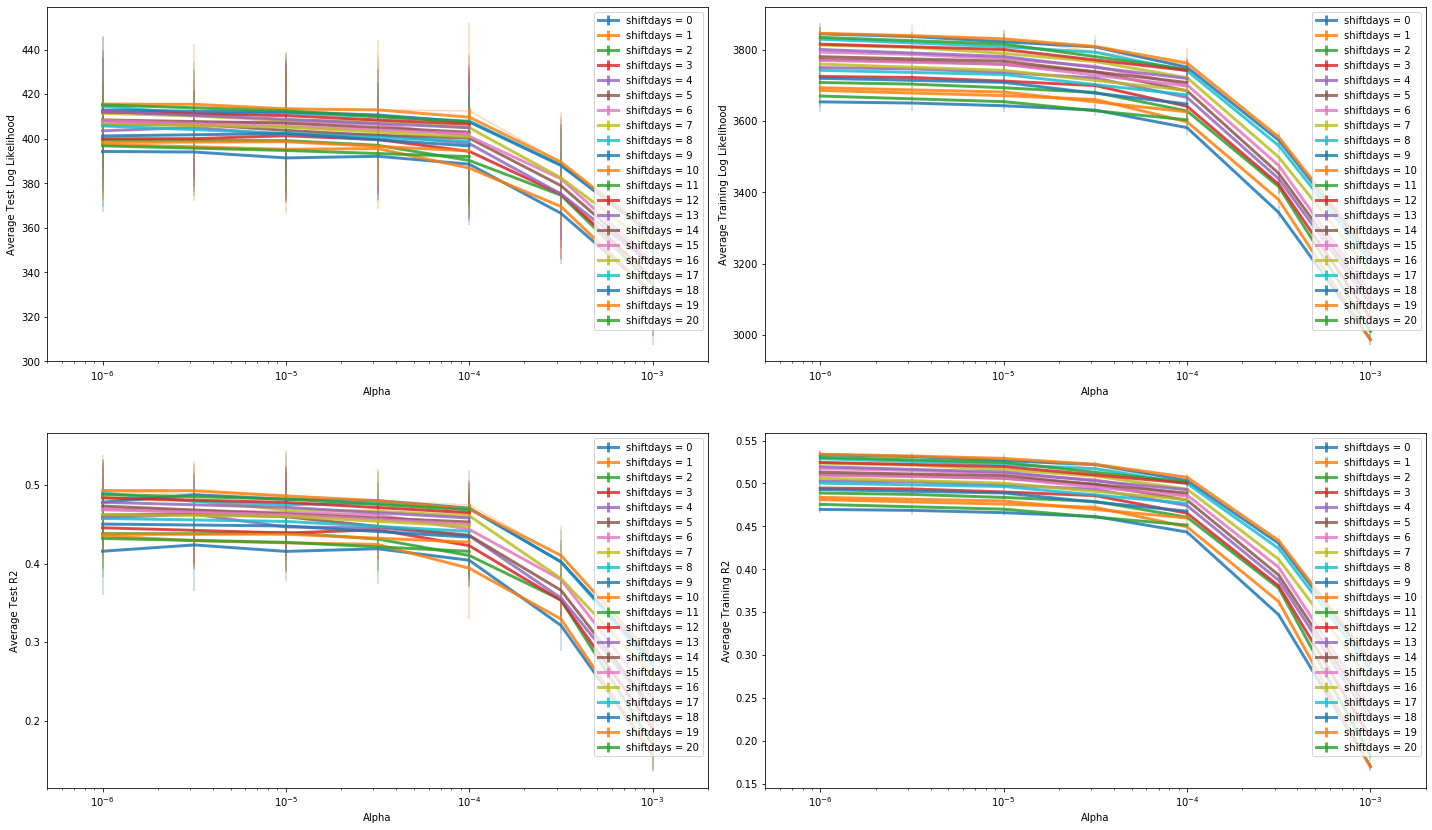

In [11]:
# various sets of calculations
filelist_nomaxlen  =  [ 'data/results_Xval_rnd10_200411_4.csv','data/results_Xval_rnd10_200411_5.csv'] \
                    + ['data/results_Xval_200412_{}.csv'.format(i) for i in range(10)] \
                    + ['data/results_smallshift_200413_{}.csv'.format(i) for i in range(10)]

filelist_maxlen    = ['results_Xval_maxlen40_200412_{}.csv'.format(i) for i in range(10)]

filelist_nocountry = glob.glob('data/*nocountry*_?.csv')

filelist_new = glob.glob('data/*200413*.csv')
filelist_oxford = ['data/results_oxforddata_200415.csv','data/results_oxforddata_200415_2.csv']

# plot test errors
markerlist = ['o','x','v','^','p','P','h','D','s','X','>','<']
colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]
alldata    = []
resDF      = None

fig,axis   = plt.subplots(2,2,figsize = (20,12))
ax         = axis.flatten()

for i,fn in enumerate(filelist_oxford):
    if os.path.exists(fn):
        print(fn)
        alldata.append(pd.read_csv(fn))

        shiftdaylist = np.array(alldata[i]['shiftdays'].unique(),dtype=np.int)
        alphalist    = alldata[i]['alpha'].unique()
        
        # compute averages and stddev with pandas
        curavg = alldata[i].groupby(['shiftdays','alpha'], as_index = False).agg(
            { 'Loglike Test':['mean','std'],
              'Loglike Training':['mean','std'],
              'R2 Test': ['mean','std'],
              'R2 Training': ['mean','std']
            })
        
        # rename columns in new DF
        curavg.columns = ['shiftdays','alpha',
                          'Loglike Test','Loglike Test Std',
                          'Loglike Training','Loglike Training Std',
                          'R2 Test','R2 Test Std',
                          'R2 Training','R2 Training Std'
                         ]
        # add more columns to identify results
        curavg['filename']  = fn
        curavg['iteration'] = i

        if resDF is None: resDF = pd.DataFrame(curavg)
        else:             resDF = pd.concat([resDF,curavg])
            
        for shiftdays in curavg['shiftdays'].unique():
            boolidx = np.array(curavg['shiftdays'] == shiftdays)
            ax[0].errorbar(alphalist, curavg[boolidx]['Loglike Test'],     yerr = curavg[boolidx]['Loglike Test Std'],     c = colornames[int(shiftdays) % len(colornames)], alpha = .3)
            ax[1].errorbar(alphalist, curavg[boolidx]['Loglike Training'], yerr = curavg[boolidx]['Loglike Training Std'], c = colornames[int(shiftdays) % len(colornames)], alpha = .3)
            ax[2].errorbar(alphalist, curavg[boolidx]['R2 Test'],          yerr = curavg[boolidx]['R2 Test Std'],          c = colornames[int(shiftdays) % len(colornames)], alpha = .3)
            ax[3].errorbar(alphalist, curavg[boolidx]['R2 Training'],      yerr = curavg[boolidx]['R2 Training Std'],      c = colornames[int(shiftdays) % len(colornames)], alpha = .3)


# compute average and plot it
alphalist    = resDF['alpha'].unique()
totalavg     = resDF.groupby(['shiftdays','alpha'], as_index = False).agg(
                            { 'Loglike Test':['mean','std'],
                              'Loglike Training':['mean','std'],
                              'R2 Test': ['mean','std'],
                              'R2 Training': ['mean','std']
                            })
        
# rename columns in new DF
totalavg.columns = ['shiftdays','alpha',
                    'Loglike Test','Loglike Test Std',
                    'Loglike Training','Loglike Training Std',
                    'R2 Test','R2 Test Std',
                    'R2 Training','R2 Training Std'
                     ]



for shiftdays in totalavg['shiftdays'].unique():
    boolidx = np.array(totalavg['shiftdays'] == shiftdays)
    alphalist = totalavg[boolidx]['alpha'].unique()
    ax[0].errorbar(alphalist, totalavg[boolidx]['Loglike Test'],     yerr = totalavg[boolidx]['Loglike Test Std'],     c = colornames[int(shiftdays) % len(colornames)], alpha = .8, lw = 3, label = 'shiftdays = {:.0f}'.format(shiftdays))
    ax[1].errorbar(alphalist, totalavg[boolidx]['Loglike Training'], yerr = totalavg[boolidx]['Loglike Training Std'], c = colornames[int(shiftdays) % len(colornames)], alpha = .8, lw = 3, label = 'shiftdays = {:.0f}'.format(shiftdays))
    ax[2].errorbar(alphalist, totalavg[boolidx]['R2 Test'],          yerr = totalavg[boolidx]['R2 Test Std'],          c = colornames[int(shiftdays) % len(colornames)], alpha = .8, lw = 3, label = 'shiftdays = {:.0f}'.format(shiftdays))
    ax[3].errorbar(alphalist, totalavg[boolidx]['R2 Training'],      yerr = totalavg[boolidx]['R2 Training Std'],      c = colornames[int(shiftdays) % len(colornames)], alpha = .8, lw = 3, label = 'shiftdays = {:.0f}'.format(shiftdays))

for i in range(4):
    ax[i].set_xlim([1e-6/2,2e-3])
    ax[i].set_xscale('log')
    ax[i].set_xlabel(r'Alpha')
    ax[i].legend()
    
ax[0].set_ylabel('Average Test Log Likelihood')
ax[1].set_ylabel('Average Training Log Likelihood')
ax[2].set_ylabel('Average Test R2')
ax[3].set_ylabel('Average Training R2')

#ax[0].set_ylim([1.12,1.34])
#ax[1].set_ylim([1.12,1.34])
#ax[2].set_ylim([.45,.63])
#ax[3].set_ylim([.45,.63])

fig.tight_layout()
plt.savefig('loglikelihood_longrun.pdf')


In [20]:
# ****************************************************************************
# **  define final model parameters here as tuples (s,alpha) *****************
# ****************************************************************************
final_meta_parameters = [(10,1e-4)]
# ****************************************************************************



formula = 'Observable ~ C(Country) + ' + ' + '.join(measurelist)
model_final   = []
results_final = []
finalCV       = None
for i,(shiftdays,alpha) in enumerate(final_meta_parameters):
    print('computing model ({},{})'.format(shiftdays,alpha))
    model_final.append(smf.ols(formula = formula, data = regrDF[shiftdays]))
    
    # first compute over whole dataset
    results_final.append(model_final[i].fit_regularized(alpha = alpha, L1_wt = 1))

    # then use CV for averages and distributions
    CVres = CrossValidation(data = regrDF[shiftdays], outputheader = {'shiftdays':shiftdays,'alpha':alpha}, alpha = alpha)
    if finalCV is None:
        finalCV = CVres
    else:
        finalCV = pd.concat([finalCV,CVres])


intercept     = [results_final[i].params['Intercept'] for i in range(len(final_meta_parameters))]
countrylist   = [paramname.split('.')[1].split(']')[0] for paramname in results_final[0].params.index if paramname[:3] == 'C(C']

# collect measure names for labels
#ml            = GetMeasureIDs(measure_level = 2,mincount = 5, extend_measure_names=True)
#measure_level_dict = {}
#for mn in ml.keys():
#    l1,l2 = mn.split(' - ')
#    if not l1 in measure_level_dict.keys():
#        measure_level_dict[l1] = {}
#    measure_level_dict[l1][l2] = CleanUpMeasureName(l2)

# amelies colorscheme...                 
colornames = ['gray','#f563e2','#609cff','#00bec4','#00b938','#b79f00','#f8766c']

                 
#colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]


computing model (10,0.0001)


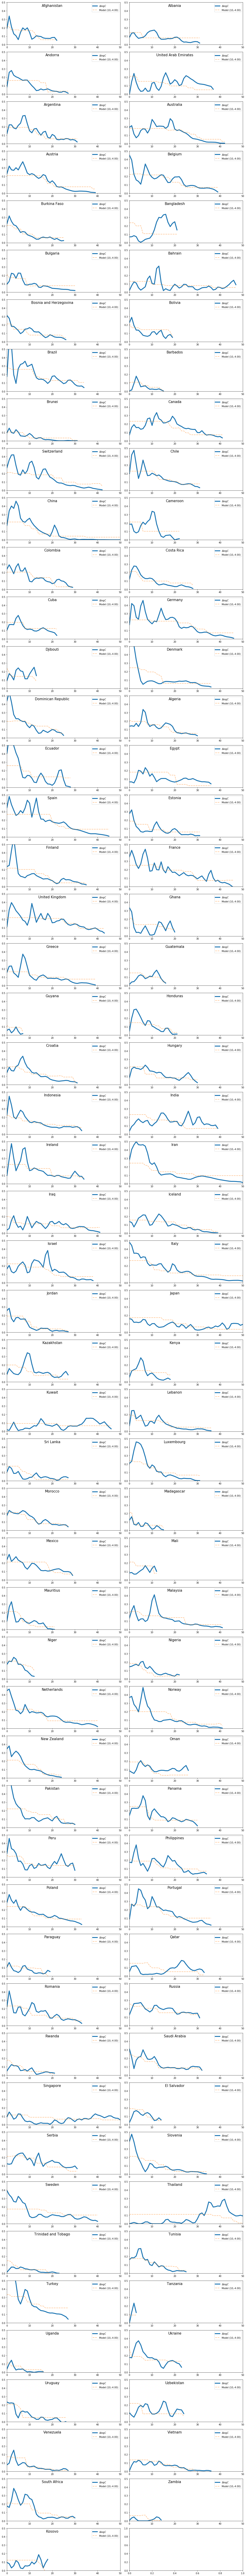

In [21]:
#specialcountries = ['Austria','Germany','Thailand', 'Italy', 'Spain', 'Sweden',
#                    'Japan', 'Hungary', 'France', 'Mexico', 'Netherlands', 'Korea, South']

colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]

specialcountries = regrDF[list(regrDF.keys())[0]]['Country'].unique()
cm = GetCountryMasks(regrDF[list(regrDF.keys())[0]])

plotxcount = int(len(specialcountries)/2) + len(specialcountries)%2

fig,ax = plt.subplots(plotxcount,2,figsize = (15,3*plotxcount))
ax = ax.flatten()

for i,country in enumerate(specialcountries):
    for j,(s,alpha) in enumerate(final_meta_parameters):
        if j == 0:
            dlc = np.array(regrDF[s][cm[country]]['Observable'])
            ax[i].plot(dlc, lw = 4, c = colornames[0], label = r'$\Delta \log C$')
        
        pred = results_final[j].predict()[cm[country]]
        ax[i].plot(pred, lw = 2, c = colornames[(j+1)%(len(colornames))], linestyle = '--', label = 'Model ({:.0f},{:.2f})'.format(s,np.log10(alpha)),alpha = .5)
    ax[i].set_ylim([0,.5])
    ax[i].set_xlim([0,50])
    ax[i].annotate(country, [20,.45],ha = 'center',fontsize = 15)
    ax[i].legend()
fig.tight_layout()
plt.savefig('regression_trajectories.pdf')


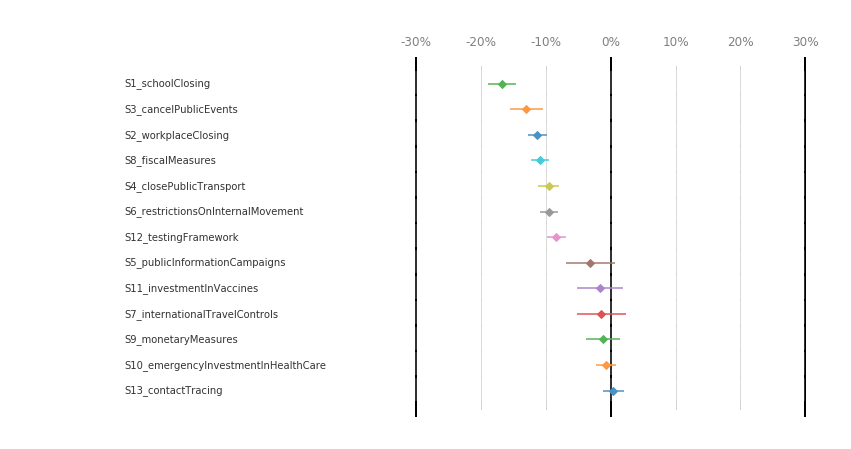

In [22]:
def modelname(index):
    return 'm{} ({},{})'.format(index,final_meta_parameters[index][0],final_meta_parameters[index][1])

colornames    = ['#f563e2','#609cff','#00bec4','#00b938','#b79f00','#f8766c']
measurecolors = {l1:col for l1,col in zip(measure_level_dict.keys(),colornames)}
model_count   = len(final_meta_parameters)
intercept     = [np.array(results_final[i].params['Intercept']) for i in range(model_count)]

inverse_mld   = {}
for l1 in measure_level_dict.keys():
    for l2 in measure_level_dict[l1].keys():
        inverse_mld[measure_level_dict[l1][l2]] = (l1,l2)

modelDF       = pd.DataFrame(columns=[modelname(i) for i in range(model_count)])

allparamnames = list(set([mn for i in range(model_count) for mn in results_final[i].params.keys() if mn[:3] != 'C(C']))
allparamnames.remove('Intercept')

for paramname in allparamnames:
    paramvaluedict = {}
    for i in range(model_count):
        paramvaluedict[modelname(i)] = float(results_final[i].params[paramname]/intercept[i])
    modelDF.loc[paramname] = paramvaluedict
    
modelDF['average'] = modelDF.mean(numeric_only = True, axis = 1)
modelDF.sort_values(by = 'average', inplace = True, ascending = False)

modelDF.to_csv('measure_effects_various_models.csv')

#print(list(modelDF.index))

l1_pos = -3
l2_pos = -2.5

def plotbox(ax, ypos = 1, label = '', color = '#ffffff', boxalpha = .2, header = False):
    background = plt.Rectangle([l2_pos - .05, ypos - .4], -l2_pos + 1.05, .9, fill = True, fc = color, alpha = boxalpha, zorder = 10)
    ax.add_patch(background)
    if not header:
        ax.annotate(label, [l2_pos,ypos-.1])
    else:
        ax.annotate(label, [l2_pos,ypos-.1], c = color, weight = 'bold')

averaged_beta = finalCV.apply(['mean','std'],axis = 0)
averaged_beta2 = finalCV.groupby(['shiftdays','alpha']).agg(['mean','std'],axis = 0)

fCVrelative = finalCV.divide(finalCV['Intercept'],axis = 0)
fCVrelative[['shiftdays','alpha']] = finalCV[['shiftdays','alpha']]
averaged_beta3 = fCVrelative.apply(['mean','std'],axis = 0).T
#averaged_beta3.sort_values(by = 'mean', ascending = False, inplace = True)

averaged_beta4 = averaged_beta3.loc[list(modelDF.index),:]
averaged_beta4.sort_values(by = 'mean', axis = 0,inplace = True,ascending = False)
#print(averaged_beta4['mean'])

betascaling = 10/3.
fig,ax = plt.subplots(figsize = (15,8))
for j,(index,values) in enumerate(averaged_beta4.iterrows()):
    #ax.annotate(inverse_mld[index][0],[l1_pos,j],c = measurecolors[inverse_mld[index][0]])
    #ax.annotate(inverse_mld[index][1],[l2_pos,j])
    plotbox(ax,ypos = j,label = index)
    ax.errorbar(np.array([averaged_beta3['mean'][index]])*betascaling,[j],xerr=2*np.array([averaged_beta3['std'][index]])*betascaling, marker = 'D')

ax.set_xlim([-3.1,1.2])

for o,vertline in enumerate(np.arange(10)*betascaling/10.):
    if vertline != 0 and -1 <= vertline  <= 1:
        ax.plot([vertline,vertline],[-.7,j+.7],c = 'lightgray',zorder = -3,lw =1)
        ax.plot([-vertline,-vertline],[-.7,j+.7],c = 'lightgray',zorder = -3,lw =1)
        ax.annotate('-{:d}%'.format(o*10),[-vertline,j+1.5],fontsize = 12,c='gray',ha='center')
        ax.annotate('{:d}%'.format(o*10),[vertline,j+1.5],fontsize = 12,c='gray',ha='center')
ax.plot([-1,-1],[-1,j+1], lw = 2, c = 'black',zorder = -2)
ax.plot([0,0],[-1,j+1], lw = 2, c = 'black', zorder = -2)
ax.plot([1,1],[-1,j+1], lw = 2, c = 'black', zorder = -2)
ax.annotate('0%',[0,j+1.5],fontsize = 12, c='gray',ha='center')

#for k,l1 in enumerate(sorted(measure_level_dict.keys())[::-1]):
#    plotbox(ax,ypos = j + k + 3, label = l1, color = measurecolors[l1], header = True)

ax.set_ylim([-2,j+3])
    
ax.axis('off')
plt.savefig('effects_measures_oxford.pdf')

